<a href="https://colab.research.google.com/github/apry0512/ML-ASSIGNMENT/blob/main/ML_ASSIGNMENT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Installing Packages
!pip install --quiet pandas numpy scikit-learn matplotlib seaborn xgboost tensorflow imbalanced-learn scikeras openpyxl plotly kaleido

print(" All packages installed successfully!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.0/69.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 4.1 MB/s eta 0:00:00
 All packages installed successfully!


In [2]:
# Uploading the dataset provided by Prof for this asiignment
from google.colab import files
import os

uploaded = files.upload()
DATA_PATH = list(uploaded.keys())[0]
print(f"\n {DATA_PATH}")

Saving wallacecommunications.csv to wallacecommunications.csv

 wallacecommunications.csv


In [3]:
# Import imp libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import json
import zipfile
from datetime import datetime

# Sklearn imports
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, classification_report,
                             roc_curve, auc, precision_recall_curve)

# Model imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# Imbalanced learning
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# NN
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from scikeras.wrappers import KerasClassifier

# Configuration
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Output pathway
OUT_DIR = Path("outputs")
OUT_DIR.mkdir(exist_ok=True)

# Constants
STUDENT_NUMBER = "3539316" # My student number at UoS
RANDOM_STATE = 42
TEST_SIZE = 0.2
VAL_SIZE = 0.25

# Setting up random seeds for consistencyyy
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

print(" Libraries imported hurraayy ig!!!!!")
print(f" Output directory: {OUT_DIR}")
print(f" My Student Number: {STUDENT_NUMBER}")

 Libraries imported hurraayy ig!!!!!
 Output directory: outputs
 My Student Number: 3539316


In [4]:
# Load dataset
print(" LOADING DATASET")

df = pd.read_csv(DATA_PATH)

print(f" Shape: {df.shape[0]:,} rows × {df.shape[1]} columns\n")

# Basic info
print(" DATASET INFO:")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"\nColumn types:")
print(df.dtypes.value_counts())

# Check missing values
print(f"\n Missing values:")
missing = df.isnull().sum()
if missing.sum() == 0:
    print(" No missing values found!!!!!!")
else:
    print(missing[missing > 0])

# Print first few rows
print("\n First 5 rows:")
display(df.head())

# Target variable analysis
if 'new_contract_this_campaign' in df.columns:
    target_col = 'new_contract_this_campaign'
    print(f"\n TARGET VARIABLE DISTRIBUTION:")
    print(df[target_col].value_counts())
    print(f"\nPositive rate: {(df[target_col] == 'yes').mean() * 100:.2f}%")
else:
    print("️Target column not found:(")

 LOADING DATASET
 Shape: 50,662 rows × 20 columns

 DATASET INFO:
Memory usage: 34.49 MB

Column types:
object     12
int64       7
float64     1
Name: count, dtype: int64

 Missing values:
 No missing values found!!!!!!

 First 5 rows:


,ID,town,country,age,job,married,education,arrears,current_balance,housing,has_tv_package,last_contact,conn_tr,last_contact_this_campaign_day,last_contact_this_campaign_month,this_campaign,days_since_last_contact_previous_campaign,contacted_during_previous_campaign,outcome_previous_campaign,new_contract_this_campaign
0,32390233,Bristol,UK,39,management,married,tertiary,no,-1.90,no,yes,unknown,4,11,jun,8,-1,0,unknown,yes
1,41226029,Basildon,UK,53,housemaid,married,primary,no,3.62,no,no,cellular,1,28,jul,2,-1,0,unknown,yes
2,85498057,Blackburn,UK,79,retired,divorced,primary,no,27.87,no,no,telephone,3,13,jul,1,377,1,success,yes
3,76539627,Oldham,UK,43,services,single,secondary,no,5.50,yes,no,cellular,3,13,may,2,-1,0,unknown,no
4,76290986,Middlesbrough,UK,35,technician,single,secondary,no,3.44,no,no,cellular,2,27,aug,16,-1,0,unknown,yes



 TARGET VARIABLE DISTRIBUTION:
new_contract_this_campaign
no     40763
yes     9899
Name: count, dtype: int64

Positive rate: 19.54%


In [5]:
# Preprocessing Data
print(" DATA PREPROCESSING")

df_clean = df.copy()

drop_cols = []
if 'ID' in df_clean.columns:
    drop_cols.append('ID')
if 'town' in df_clean.columns:
    drop_cols.append('town')

if drop_cols:
    print(f"\n️ Dropping columns: {drop_cols}")
    df_clean = df_clean.drop(columns=drop_cols)

df_clean['new_contract_this_campaign'] = df_clean['new_contract_this_campaign'].map({'yes': 1, 'no': 0})
print(f" Target encoded: 'yes' → 1, 'no' → 0")

numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [c for c in numeric_cols if c != 'new_contract_this_campaign']
categorical_cols = df_clean.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"\n Column types identified:")
print(f"   • Numeric: {len(numeric_cols)} columns")
print(f"   • Categorical: {len(categorical_cols)} columns")

print(f"\n Handling missing values...")
for col in numeric_cols:
    if df_clean[col].isnull().any():
        median_val = df_clean[col].median()
        df_clean[col].fillna(median_val, inplace=True)
        print(f"   • {col}: filled with median ({median_val:.2f})")

for col in categorical_cols:
    if df_clean[col].isnull().any():
        df_clean[col].fillna('MISSING', inplace=True)
        print(f"   • {col}: filled with 'MISSING'")

high_card_cols = [col for col in categorical_cols if df_clean[col].nunique() > 100]
if high_card_cols:
    print(f"\n️ Removing high-cardinality columns: {high_card_cols}")
    df_clean = df_clean.drop(columns=high_card_cols)
    categorical_cols = [c for c in categorical_cols if c not in high_card_cols]

df_encoded = pd.get_dummies(df_clean, columns=categorical_cols, drop_first=True)
print(f" Encoding DONE!!!!!!")
print(f"   • Original features: {len(numeric_cols) + len(categorical_cols)}")
print(f"   • Encoded features: {df_encoded.shape[1] - 1}")

X = df_encoded.drop(columns=['new_contract_this_campaign'])
y = df_encoded['new_contract_this_campaign'].astype(int)

print(f"\n PREPROCESSING DONE- PREPROCESSED OR PREPOSSESSED!!!!!......I'M SLEEP DEPRIVED")
print(f"   • Final shape: {X.shape}")
print(f"   • Class distribution: {dict(y.value_counts())}")
print(f"   • Class imbalance ratio: 1:{(y==0).sum()/(y==1).sum():.2f}")

 DATA PREPROCESSING

️ Dropping columns: ['ID', 'town']
 Target encoded: 'yes' → 1, 'no' → 0

 Column types identified:
   • Numeric: 7 columns
   • Categorical: 10 columns

 Handling missing values...
 Encoding DONE!!!!!!
   • Original features: 17
   • Encoded features: 49

 PREPROCESSING DONE- PREPROCESSED OR PREPOSSESSED!!!!!......I'M SLEEP DEPRIVED
   • Final shape: (50662, 49)
   • Class distribution: {0: np.int64(40763), 1: np.int64(9899)}
   • Class imbalance ratio: 1:4.12


In [10]:
# Train/Validate/Split
print("DATA PREPROCESSING & SPLIT")

df_proc = df.copy()

drop_cols = []
if 'ID' in df_proc.columns:
    drop_cols.append('ID')
    print(f"Dropping ID column: {drop_cols}")
    df_proc = df_proc.drop(columns=drop_cols)

if 'new_contract_this_campaign' in df_proc.columns:
    df_proc['new_contract_this_campaign'] = df_proc['new_contract_this_campaign'].map({'yes': 1, 'no': 0})
    print(f"Target encoded: 'yes' -> 1, 'no' -> 0")
else:
    print("Warning: Target column NOT Found for encoding!!!!")

if 'new_contract_this_campaign' in df_proc.columns:
    X = df_proc.drop(columns=['new_contract_this_campaign'])
    y = df_proc['new_contract_this_campaign'].astype(int)
else:
    X = df_proc
    y = pd.Series([0] * len(X))

print(f"\nInitial X shape: {X.shape}")
print(f"Initial y shape: {y.shape}")

categorical_cols_temp = X.select_dtypes(include=['object', 'category']).columns.tolist()
high_card_cols = [col for col in categorical_cols_temp if X[col].nunique() > 100]

if high_card_cols:
    print(f"\nRemoving high-cardinality columns (>100 unique values):")
    for col in high_card_cols:
        print(f"   • {col}: {X[col].nunique()} unique values")
    X = X.drop(columns=high_card_cols)

print("Final Feature Types:")
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"\nNumeric columns ({len(numeric_cols)}):")
for col in numeric_cols:
    print(f"   • {col}")

print(f"\nCategorical columns ({len(categorical_cols)}):")
for col in categorical_cols:
    nunique = X[col].nunique()
    print(f"   • {col}: {nunique} unique values")

total_cols = len(numeric_cols) + len(categorical_cols)
print(f"\nTotal columns: {total_cols} (should equal {X.shape[1]})")
if total_cols != X.shape[1]:
    print("Some columns are not categorized!!!!!")
    uncategorized = set(X.columns) - set(numeric_cols) - set(categorical_cols)
    print(f"   Uncategorized: {uncategorized}")

# Split the data (Train/Validation/Test)
print("Stratified Data Splitting:")

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    stratify=y,
    random_state=RANDOM_STATE
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=VAL_SIZE,
    stratify=y_temp,
    random_state=RANDOM_STATE
)

print(f"\n{'Set':<12} {'Size':<12} {'Percentage':<12} {'Class 0':<12} {'Class 1':<12}")

total_size = len(X)
for name, X_set, y_set in [('Train', X_train, y_train),
                            ('Validation', X_val, y_val),
                            ('Test', X_test, y_test)]:
    size = len(X_set)
    pct = size / total_size * 100
    class_0 = (y_set == 0).sum()
    class_1 = (y_set == 1).sum()
    print(f"{name:<12} {size:<12,} {pct:<11.1f}% {class_0:<12,} {class_1:<12,}")


# Final verification
print("\nColumn Consistency Check:")
print(f"   • X_train shape: {X_train.shape}")
print(f"   • X_val shape: {X_val.shape}")
print(f"   • X_test shape: {X_test.shape}")
print(f"   • All splits have same columns: {X_train.columns.equals(X_val.columns) and X_train.columns.equals(X_test.columns)}")

# Verify column lists match actual data
print("\nVerifying column lists match training data:")
numeric_match = all(col in X_train.columns for col in numeric_cols)
categorical_match = all(col in X_train.columns for col in categorical_cols)

print(f"   • Numeric columns match: {numeric_match}")
print(f"   • Categorical columns match: {categorical_match}")

if not numeric_match:
    missing = [col for col in numeric_cols if col not in X_train.columns]
    print(f"    Missing numerical columns: {missing}")

if not categorical_match:
    missing = [col for col in categorical_cols if col not in X_train.columns]
    print(f"    Missing categorical columns: {missing}")

if numeric_match and categorical_match:
    print(" DATA PREPROCESSING COMPLETE - Ready for modeling!!!")
else:
    print("Column mismatch detected!")

DATA PREPROCESSING & SPLIT
Dropping ID column: ['ID']
Target encoded: 'yes' -> 1, 'no' -> 0

Initial X shape: (50662, 18)
Initial y shape: (50662,)

Removing high-cardinality columns (>100 unique values):
   • town: 101 unique values
Final Feature Types:

Numeric columns (7):
   • age
   • current_balance
   • conn_tr
   • last_contact_this_campaign_day
   • this_campaign
   • days_since_last_contact_previous_campaign
   • contacted_during_previous_campaign

Categorical columns (10):
   • country: 5 unique values
   • job: 12 unique values
   • married: 3 unique values
   • education: 4 unique values
   • arrears: 2 unique values
   • housing: 2 unique values
   • has_tv_package: 3 unique values
   • last_contact: 4 unique values
   • last_contact_this_campaign_month: 13 unique values
   • outcome_previous_campaign: 4 unique values

Total columns: 17 (should equal 17)
Stratified Data Splitting:

Set          Size         Percentage   Class 0      Class 1     
Train        30,396       

In [7]:
# ML MODELS- kNN, Neural Networks, XGBoost, Random Forest
print("MODEL ARCHITECTURE SETUP")

# Cross-validation strategy
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

print("\nModels to be trained:")
print("   1. Random Forest Classifier")
print("   2. XGBoost Classifier")
print("   3. k-Nearest Neighbors (with SMOTE)")
print("   4. Neural Network (with SMOTE)")

print("\nPreprocessing will be applied within each model pipeline:")
print("   • Numeric features: Median imputation + StandardScaler")
print("   • Categorical features: Constant imputation + OneHotEncoder")

MODEL ARCHITECTURE SETUP

Models to be trained:
   1. Random Forest Classifier
   2. XGBoost Classifier
   3. k-Nearest Neighbors (with SMOTE)
   4. Neural Network (with SMOTE)

Preprocessing will be applied within each model pipeline:
   • Numeric features: Median imputation + StandardScaler
   • Categorical features: Constant imputation + OneHotEncoder


In [11]:
# Hyperparameter Tuning
print("HYPERPARAMETER TUNING (RANDOMIZED SEARCH)")

# Import all necessary libraries
import joblib
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from tensorflow import keras
from tensorflow.keras import layers
from scikeras.wrappers import KerasClassifier

# Store all search results
search_results = {}
best_models = {}

print("\nMODEL 1: RANDOM FOREST")

# Create a fresh preprocessor for Random Forest
rf_preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_cols),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='MISSING')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False))
        ]), categorical_cols)
    ],
    remainder='drop'
)

rf_pipeline = Pipeline([
    ('preprocessor', rf_preprocessor),
    ('classifier', RandomForestClassifier(
        class_weight='balanced',
        random_state=RANDOM_STATE,
        n_jobs=-1
    ))
])

rf_param_dist = {
    'classifier__n_estimators': [100, 200, 300, 500],
    'classifier__max_depth': [10, 20, 30, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': ['sqrt', 'log2']
}

rf_search = RandomizedSearchCV(
    rf_pipeline,
    rf_param_dist,
    n_iter=20,
    cv=cv_strategy,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=1
)

print("Training Random Forest with RandomizedSearchCV...")
rf_search.fit(X_train, y_train)
search_results['RandomForest'] = rf_search
best_models['RandomForest'] = rf_search.best_estimator_

print(f"\n Random Forest Training Complete!!!")
print(f"   • Best CV ROC-AUC: {rf_search.best_score_:.4f}")
print(f"   • Best params: {rf_search.best_params_}")

print("\nMODEL 2: XGBOOST")

# Create a fresh preprocessor for XGBoost
xgb_preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_cols),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='MISSING')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False))
        ]), categorical_cols)
    ],
    remainder='drop'
)

xgb_pipeline = Pipeline([
    ('preprocessor', xgb_preprocessor),
    ('classifier', XGBClassifier(
        eval_metric='logloss',
        use_label_encoder=False,
        random_state=RANDOM_STATE,
        n_jobs=-1
    ))
])

# Calculate scale_pos_weight for class imbalance
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

xgb_param_dist = {
    'classifier__n_estimators': [100, 200, 300, 500],
    'classifier__max_depth': [3, 5, 7, 9],
    'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'classifier__subsample': [0.6, 0.8, 1.0],
    'classifier__colsample_bytree': [0.6, 0.8, 1.0],
    'classifier__scale_pos_weight': [1, scale_pos_weight]
}

xgb_search = RandomizedSearchCV(
    xgb_pipeline,
    xgb_param_dist,
    n_iter=20,
    cv=cv_strategy,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=1
)

print("Training XGBoost with RandomizedSearchCV...")
xgb_search.fit(X_train, y_train)
search_results['XGBoost'] = xgb_search
best_models['XGBoost'] = xgb_search.best_estimator_

print(f"\n XGBoost Training Complete!!!!!!!!")
print(f"   • Best CV ROC-AUC: {xgb_search.best_score_:.4f}")
print(f"   • Best params: {xgb_search.best_params_}")

print("\nMODEL 3: K-NEAREST NEIGHBORS")

# Create a fresh preprocessor for kNN
knn_preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_cols),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='MISSING')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False))
        ]), categorical_cols)
    ],
    remainder='drop'
)

# Use ImbPipeline for SMOTE
knn_pipeline = ImbPipeline([
    ('preprocessor', knn_preprocessor),
    ('smote', SMOTE(random_state=RANDOM_STATE)),
    ('classifier', KNeighborsClassifier(n_jobs=-1))
])

knn_param_dist = {
    'classifier__n_neighbors': [3, 5, 7, 9, 11, 15],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__p': [1, 2],  # 1=Manhattan, 2=Euclidean
    'classifier__leaf_size': [20, 30, 40]
}

knn_search = RandomizedSearchCV(
    knn_pipeline,
    knn_param_dist,
    n_iter=15,
    cv=cv_strategy,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=1
)

print("Training k-NN with SMOTE and RandomizedSearchCV...")
knn_search.fit(X_train, y_train)
search_results['kNN'] = knn_search
best_models['kNN'] = knn_search.best_estimator_

print(f"\n k-NN Training Complete!!!!")
print(f"   • Best CV ROC-AUC: {knn_search.best_score_:.4f}")
print(f"   • Best params: {knn_search.best_params_}")

print("\nMODEL 4: NEURAL NETWORK")

# Create a fresh preprocessor for Neural Network
nn_preprocessor_temp = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_cols),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='MISSING')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False))
        ]), categorical_cols)
    ],
    remainder='drop'
)

# Calculate input dimension by fitting the preprocessor
nn_preprocessor_temp.fit(X_train)
input_dim = nn_preprocessor_temp.transform(X_train[:1]).shape[1]
print(f"Calculated Neural Network input dimension: {input_dim}")

# Define create_nn_model as a proper callable class
class NeuralNetworkBuilder:
    def __init__(self, input_dim):
        self.input_dim = input_dim

    def __call__(self, hidden_units=64, dropout_rate=0.3, learning_rate=0.001):
        """Build a neural network for binary classification"""
        model = keras.Sequential([
            layers.Input(shape=(self.input_dim,)),
            layers.Dense(hidden_units, activation='relu',
                        kernel_regularizer=keras.regularizers.l2(0.001)),
            layers.BatchNormalization(),
            layers.Dropout(dropout_rate),
            layers.Dense(hidden_units // 2, activation='relu',
                        kernel_regularizer=keras.regularizers.l2(0.001)),
            layers.BatchNormalization(),
            layers.Dropout(dropout_rate / 2),
            layers.Dense(1, activation='sigmoid')
        ])

        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
            loss='binary_crossentropy',
            metrics=['AUC']
        )

        return model

# Create the model builder instance
nn_model_builder = NeuralNetworkBuilder(input_dim)

# Create a new preprocessor instance for the pipeline
nn_preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_cols),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='MISSING')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False))
        ]), categorical_cols)
    ],
    remainder='drop'
)

nn_pipeline = ImbPipeline([
    ('preprocessor', nn_preprocessor),
    ('smote', SMOTE(random_state=RANDOM_STATE)),
    ('classifier', KerasClassifier(
        model=nn_model_builder,
        epochs=30,
        batch_size=64,
        verbose=0
    ))
])

nn_param_dist = {
    'classifier__model__hidden_units': [32, 64, 128],
    'classifier__model__dropout_rate': [0.2, 0.3, 0.4],
    'classifier__model__learning_rate': [0.001, 0.0005],
    'classifier__epochs': [20, 30],
    'classifier__batch_size': [32, 64]
}

nn_search = RandomizedSearchCV(
    nn_pipeline,
    nn_param_dist,
    n_iter=6,  # Reduced for faster training
    cv=3,  # Reduced CV folds for NN
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=1,  # NN training should be sequential
    verbose=1,
    error_score='raise'  # Raise errors to see what's going wrong
)

print("Training Neural Network with SMOTE and RandomizedSearchCV...")

try:
    nn_search.fit(X_train, y_train)
    search_results['NeuralNetwork'] = nn_search
    best_models['NeuralNetwork'] = nn_search.best_estimator_

    print(f"\n Neural Network Training Complete!!!!")
    print(f"   • Best CV ROC-AUC: {nn_search.best_score_:.4f}")
    print(f"   • Best params: {nn_search.best_params_}")

except Exception as e:
    print(f"\n Neural Network training encountered an error:")
    print(f"   Error: {str(e)[:300]}")
    print("   Continuing with other models...")
    import traceback
    traceback.print_exc()

print("HYPERPARAMETER TUNING SUMMARY")
print(f"\n{'Model':<20} {'Best CV ROC-AUC':<20}")

for name, search in search_results.items():
    print(f"{name:<20} {search.best_score_:<20.4f}")

if len(search_results) >= 3:
    print(" MODEL TRAINING COMPLETE!!!")
else:
    print(" SOME MODELS TRAINED SUCCESSFULLY!!!!")

HYPERPARAMETER TUNING (RANDOMIZED SEARCH)

MODEL 1: RANDOM FOREST
Training Random Forest with RandomizedSearchCV...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

 Random Forest Training Complete!!!
   • Best CV ROC-AUC: 0.8746
   • Best params: {'classifier__n_estimators': 200, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 1, 'classifier__max_features': 'log2', 'classifier__max_depth': 30}

MODEL 2: XGBOOST
Training XGBoost with RandomizedSearchCV...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

 XGBoost Training Complete!!!!!!!!
   • Best CV ROC-AUC: 0.8582
   • Best params: {'classifier__subsample': 0.8, 'classifier__scale_pos_weight': np.float64(4.118033338945951), 'classifier__n_estimators': 200, 'classifier__max_depth': 9, 'classifier__learning_rate': 0.2, 'classifier__colsample_bytree': 0.8}

MODEL 3: K-NEAREST NEIGHBORS
Training k-NN with SMOTE and RandomizedSearchCV...
Fitting 5 folds for each of 15 candidates, totalling 7

Traceback (most recent call last):
  File "/tmp/ipython-input-1636827282.py", line 291, in <cell line: 0>
    nn_search.fit(X_train, y_train)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py", line 1024, in fit
    self._run_search(evaluate_candidates)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py", line 1951, in _run_search
    evaluate_candidates(
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py", line 970, in evaluate_candidates
    out = parallel(
          ^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/utils/parallel.py", line 77, in __call__
    return super().__call__(iterable_with_config)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/

In [12]:
# Validation Set Evaluation
print("VALIDATION SET EVALUATION")

def evaluate_model(model, X, y, set_name="Validation"):
    """Comprehensive model evaluation"""
    # Get probabilities (required for ROC-AUC)
    y_proba = model.predict_proba(X)

    # Handle different output formats
    if y_proba.ndim > 1 and y_proba.shape[1] > 1:
        y_proba = y_proba[:, 1]
    elif y_proba.ndim > 1 and y_proba.shape[1] == 1:
        y_proba = y_proba.flatten()

    # Get class predictions
    y_pred = (y_proba > 0.5).astype(int)

    # Calculate metrics
    metrics = {
        'accuracy': accuracy_score(y, y_pred),
        'precision': precision_score(y, y_pred, zero_division=0),
        'recall': recall_score(y, y_pred, zero_division=0),
        'f1': f1_score(y, y_pred, zero_division=0),
        'roc_auc': roc_auc_score(y, y_proba)
    }

    return metrics, y_pred, y_proba

# Evaluate all models
validation_results = {}

print("\nEvaluating models on validation set...")
for model_name, model in best_models.items():
    print(f"\nEvaluating {model_name}...")
    metrics, y_pred, y_proba = evaluate_model(model, X_val, y_val, "Validation")
    validation_results[model_name] = {
        'metrics': metrics,
        'y_pred': y_pred,
        'y_proba': y_proba
    }

    print(f"   • ROC-AUC:   {metrics['roc_auc']:.4f}")
    print(f"   • Accuracy:  {metrics['accuracy']:.4f}")
    print(f"   • Precision: {metrics['precision']:.4f}")
    print(f"   • Recall:    {metrics['recall']:.4f}")
    print(f"   • F1-Score:  {metrics['f1']:.4f}")

# Select best model based on ROC-AUC
best_model_name = max(validation_results.keys(),
                      key=lambda k: validation_results[k]['metrics']['roc_auc'])
best_model = best_models[best_model_name]
best_roc_auc = validation_results[best_model_name]['metrics']['roc_auc']

print(f"\nBEST MODEL SELECTED: {best_model_name}")
print(f"   • Validation ROC-AUC: {best_roc_auc:.4f}")

VALIDATION SET EVALUATION

Evaluating models on validation set...

Evaluating RandomForest...
   • ROC-AUC:   0.8996
   • Accuracy:  0.8910
   • Precision: 0.8359
   • Recall:    0.5505
   • F1-Score:  0.6638

Evaluating XGBoost...
   • ROC-AUC:   0.8806
   • Accuracy:  0.8821
   • Precision: 0.6940
   • Recall:    0.7091
   • F1-Score:  0.7015

Evaluating kNN...
   • ROC-AUC:   0.8323
   • Accuracy:  0.7945
   • Precision: 0.4821
   • Recall:    0.6944
   • F1-Score:  0.5691

BEST MODEL SELECTED: RandomForest
   • Validation ROC-AUC: 0.8996


In [13]:
# Final Test Evaluation
print("FINAL TEST SET EVALUATION")

# Evaluate final model on test set
print(f"\nEvaluating {best_model_name} on held-out test set...\n")

test_metrics, y_test_pred, y_test_proba = evaluate_model(best_model, X_test, y_test, "Test")

print("FINAL TEST RESULTS")
print(f"\n{'Metric':<20} {'Value':<10}")
print("-"*30)
for metric, value in test_metrics.items():
    print(f"{metric.upper():<20} {value:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
print(f"\nConfusion Matrix:")
print("-"*30)
print(f"{'':>15} Predicted")
print(f"{'':>10} {'No':<10} {'Yes':<10}")
print(f"{'Actual':<8} No  {cm[0,0]:<10} {cm[0,1]:<10}")
print(f"{'':>8} Yes {cm[1,0]:<10} {cm[1,1]:<10}")

# Classification Report
print(f"\nDetailed Classification Report:")
print(classification_report(y_test, y_test_pred, target_names=['No Contract', 'New Contract']))

# Save model
model_filename = OUT_DIR / f"best_model_{STUDENT_NUMBER}_{best_model_name}.pkl"
joblib.dump(best_model, model_filename)
print(f"\nModel saved: {model_filename}")

print("\nTest evaluation complete!!!!")

FINAL TEST SET EVALUATION

Evaluating RandomForest on held-out test set...

FINAL TEST RESULTS

Metric               Value     
------------------------------
ACCURACY             0.8922
PRECISION            0.8328
RECALL               0.5611
F1                   0.6705
ROC_AUC              0.9005

Confusion Matrix:
------------------------------
                Predicted
           No         Yes       
Actual   No  7930       223       
         Yes 869        1111      

Detailed Classification Report:
              precision    recall  f1-score   support

 No Contract       0.90      0.97      0.94      8153
New Contract       0.83      0.56      0.67      1980

    accuracy                           0.89     10133
   macro avg       0.87      0.77      0.80     10133
weighted avg       0.89      0.89      0.88     10133


Model saved: outputs/best_model_3539316_RandomForest.pkl

Test evaluation complete!!!!


CREATING VISUALIZATIONS


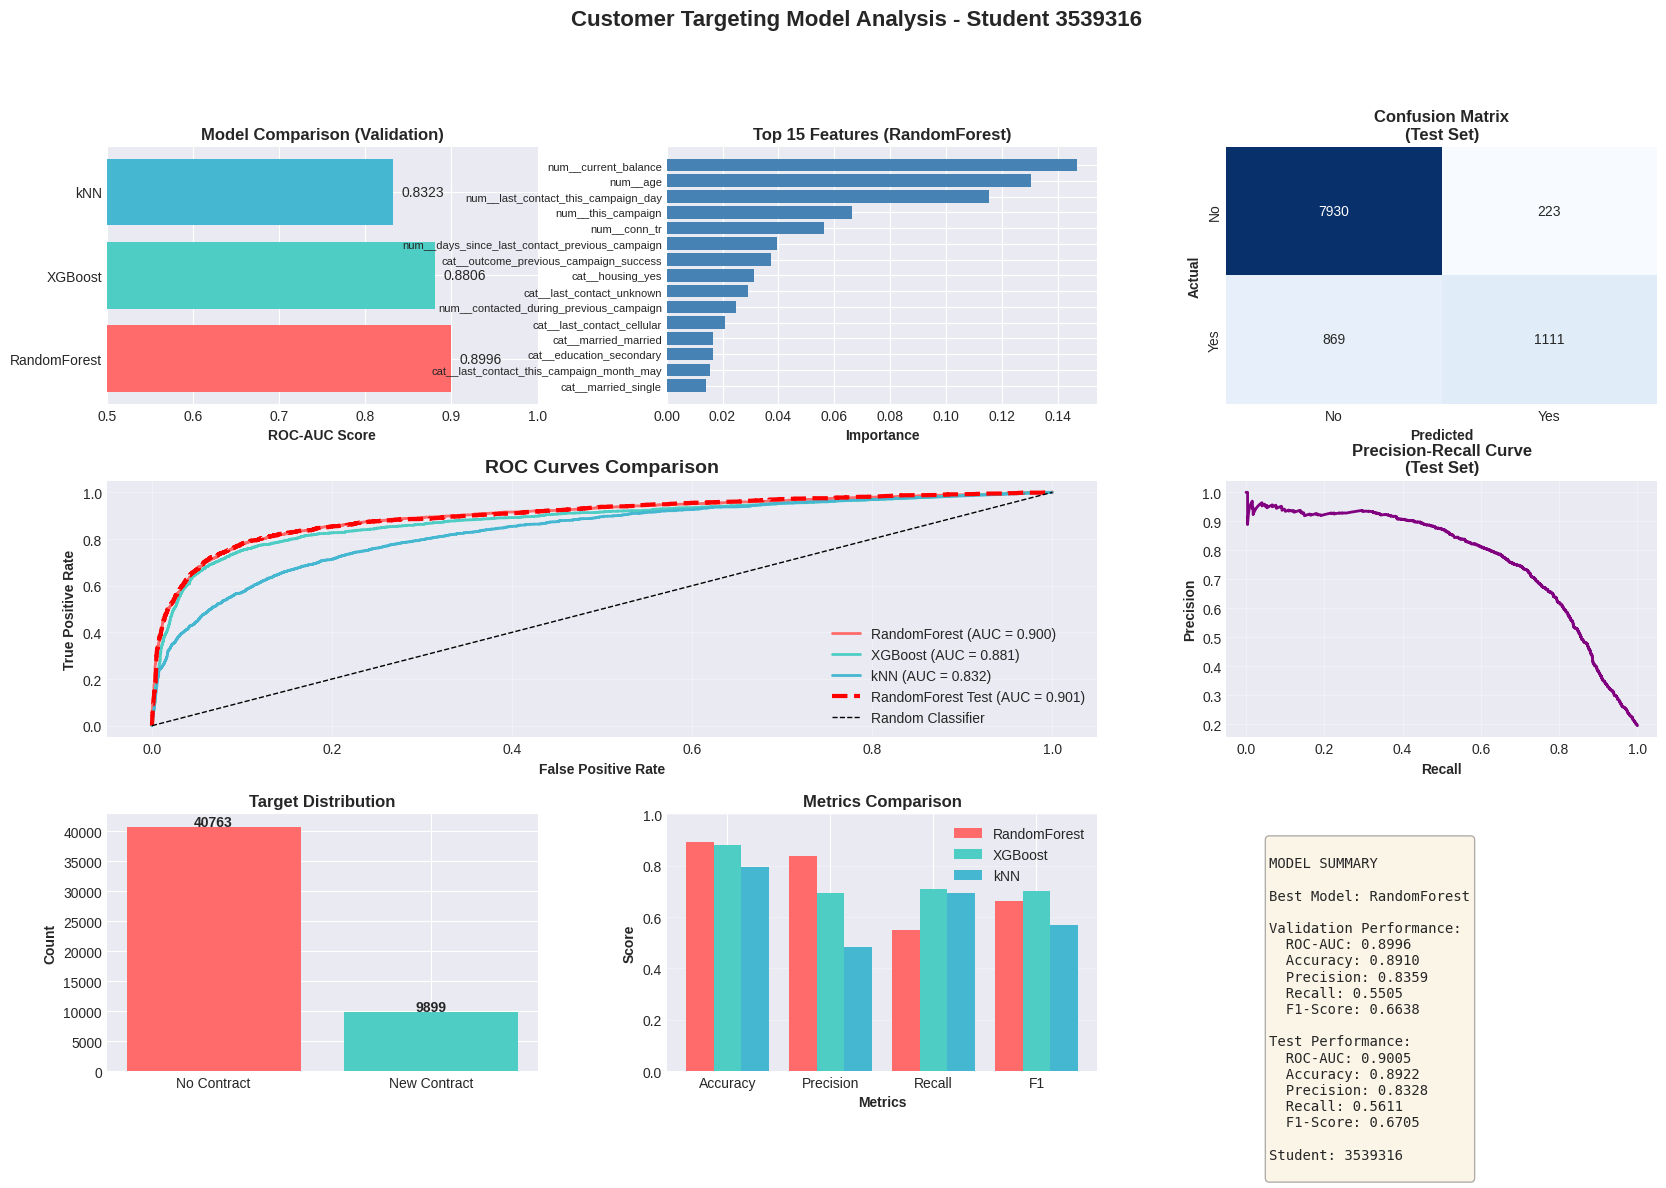


Plots saved: outputs/model_evaluation_plots_3539316.png

Visualizations complete!

 STUDENT- APARAJITA SINGH


In [14]:
# Visualizations
print("CREATING VISUALIZATIONS")

# Create figure for multiple plots
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Model Comparison - ROC-AUC
ax1 = fig.add_subplot(gs[0, 0])
model_names = list(validation_results.keys())
roc_aucs = [validation_results[m]['metrics']['roc_auc'] for m in model_names]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']
bars = ax1.barh(model_names, roc_aucs, color=colors[:len(model_names)])
ax1.set_xlabel('ROC-AUC Score', fontweight='bold')
ax1.set_title('Model Comparison (Validation)', fontweight='bold', fontsize=12)
ax1.set_xlim([0.5, 1.0])
for i, (bar, val) in enumerate(zip(bars, roc_aucs)):
    ax1.text(val + 0.01, i, f'{val:.4f}', va='center')

# 2. Feature Importance
ax2 = fig.add_subplot(gs[0, 1])
try:
    classifier = best_model.named_steps['classifier']
    if hasattr(classifier, 'feature_importances_'):
        importances = classifier.feature_importances_
        feature_names_out = best_model.named_steps['preprocessor'].get_feature_names_out()
        feature_names = [name for name in feature_names_out if not name.startswith('remainder')]

        if len(importances) == len(feature_names):
            indices = np.argsort(importances)[-15:]  # Top 15
            ax2.barh(range(len(indices)), importances[indices], color='steelblue')
            ax2.set_yticks(range(len(indices)))
            ax2.set_yticklabels([feature_names[i] for i in indices], fontsize=8)
            ax2.set_xlabel('Importance', fontweight='bold')
            ax2.set_title(f'Top 15 Features ({best_model_name})', fontweight='bold', fontsize=12)
        else:
            raise ValueError("Feature length mismatch")
    else:
        raise AttributeError("No feature importances")
except Exception as e:
    ax2.text(0.5, 0.5, f'Feature importance\nnot available\nfor {best_model_name}',
             ha='center', va='center', fontsize=12)
    ax2.axis('off')

# 3. Confusion Matrix Heatmap
ax3 = fig.add_subplot(gs[0, 2])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax3,
            xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
ax3.set_xlabel('Predicted', fontweight='bold')
ax3.set_ylabel('Actual', fontweight='bold')
ax3.set_title(f'Confusion Matrix\n(Test Set)', fontweight='bold', fontsize=12)

# 4. ROC Curves for all models
ax4 = fig.add_subplot(gs[1, :2])
for i, (model_name, results) in enumerate(validation_results.items()):
    fpr, tpr, _ = roc_curve(y_val, results['y_proba'])
    roc_auc = auc(fpr, tpr)
    ax4.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.3f})',
             color=colors[i] if i < len(colors) else None)

# Test set ROC for best model
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)
roc_auc_test = auc(fpr_test, tpr_test)
ax4.plot(fpr_test, tpr_test, lw=3, linestyle='--',
         label=f'{best_model_name} Test (AUC = {roc_auc_test:.3f})', color='red')

ax4.plot([0, 1], [0, 1], 'k--', lw=1, label='Random Classifier')
ax4.set_xlabel('False Positive Rate', fontweight='bold')
ax4.set_ylabel('True Positive Rate', fontweight='bold')
ax4.set_title('ROC Curves Comparison', fontweight='bold', fontsize=14)
ax4.legend(loc='lower right')
ax4.grid(alpha=0.3)

# 5. Precision-Recall Curve
ax5 = fig.add_subplot(gs[1, 2])
precision, recall, _ = precision_recall_curve(y_test, y_test_proba)
ax5.plot(recall, precision, lw=2, color='purple')
ax5.set_xlabel('Recall', fontweight='bold')
ax5.set_ylabel('Precision', fontweight='bold')
ax5.set_title('Precision-Recall Curve\n(Test Set)', fontweight='bold', fontsize=12)
ax5.grid(alpha=0.3)

# 6. Class Distribution
ax6 = fig.add_subplot(gs[2, 0])
class_counts = y.value_counts()
bars = ax6.bar(['No Contract', 'New Contract'], class_counts.values, color=['#FF6B6B', '#4ECDC4'])
ax6.set_ylabel('Count', fontweight='bold')
ax6.set_title('Target Distribution', fontweight='bold', fontsize=12)
for i, v in enumerate(class_counts.values):
    ax6.text(i, v + 50, str(v), ha='center', fontweight='bold')

# 7. Metric Comparison Across Models
ax7 = fig.add_subplot(gs[2, 1])
metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1']
x = np.arange(len(metrics_to_plot))
width = 0.8 / len(validation_results)

for i, (model_name, results) in enumerate(validation_results.items()):
    values = [results['metrics'][m] for m in metrics_to_plot]
    offset = (i - len(validation_results)/2) * width + width/2
    ax7.bar(x + offset, values, width, label=model_name,
            color=colors[i] if i < len(colors) else None)

ax7.set_xlabel('Metrics', fontweight='bold')
ax7.set_ylabel('Score', fontweight='bold')
ax7.set_title('Metrics Comparison', fontweight='bold', fontsize=12)
ax7.set_xticks(x)
ax7.set_xticklabels([m.capitalize() for m in metrics_to_plot])
ax7.legend()
ax7.set_ylim([0, 1])
ax7.grid(axis='y', alpha=0.3)

# 8. Training Summary Table
ax8 = fig.add_subplot(gs[2, 2])
ax8.axis('off')

summary_text = f"""
MODEL SUMMARY

Best Model: {best_model_name}

Validation Performance:
  ROC-AUC: {best_roc_auc:.4f}
  Accuracy: {validation_results[best_model_name]['metrics']['accuracy']:.4f}
  Precision: {validation_results[best_model_name]['metrics']['precision']:.4f}
  Recall: {validation_results[best_model_name]['metrics']['recall']:.4f}
  F1-Score: {validation_results[best_model_name]['metrics']['f1']:.4f}

Test Performance:
  ROC-AUC: {test_metrics['roc_auc']:.4f}
  Accuracy: {test_metrics['accuracy']:.4f}
  Precision: {test_metrics['precision']:.4f}
  Recall: {test_metrics['recall']:.4f}
  F1-Score: {test_metrics['f1']:.4f}

Student: {STUDENT_NUMBER}
"""

ax8.text(0.1, 0.9, summary_text, transform=ax8.transAxes,
         fontsize=10, verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.suptitle(f'Customer Targeting Model Analysis - Student {STUDENT_NUMBER}',
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# Save the figure
fig_filename = OUT_DIR / f"model_evaluation_plots_{STUDENT_NUMBER}.png"
fig.savefig(fig_filename, dpi=150, bbox_inches='tight')
print(f"\nPlots saved: {fig_filename}")

print("\nVisualizations complete!")
print("\n STUDENT- APARAJITA SINGH")